# Sky Almanac

This notebook contains some useful tools for planning the observations. 
It calculates the sunrise/sunset and the end/beginning of each twilight based on calculations using the coordinates of Rubin and AstroPy.

## Import Libraries

These are the libraries that we will need to run this notebook.

In [1]:
from astropy import coordinates as coord
from astropy import units as u
from astropy.time import Time, TimezoneInfo 
from datetime import datetime

import cycler
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import pytz

## Set Up

Here are the main configuration variables that propagate accross all the functions.

In [2]:
rubin_obs = coord.EarthLocation(
    lat='-30:14:40.68', lon='-70:44:57.90', height=2647 * u.m)

tz = TimezoneInfo(utc_offset=-3*u.hour)

In [3]:
# targets = ['HD 167060', 'HD 185975', '18 Sco', 'HD 185975', 'HD 111980', 'HD 185975']
targets = ['HD 14943', 'HD 185975', 'HD 031128', 'HD 185975', 'HD 074000', 
           'HD 185975']

_date = "20220216"  # Begin of the night

## Helper Functions

These are functions used later in the notebook

In [4]:
def get_alt(t, location, time):
    """
    Get the Alt (Elevation) for a given target at a given location and at a 
    given time.
    
    Parameters
    ----------
    t : string
        Target name to be queried via Simbad.
    location : astropy.coordinates.EarthLocation
        Location of the observatory.
    time : astropy.time.Time
        Time of the observation 
        
    Returns
    -------
    float : the airmass of the object in degrees.
    """
    c = coord.SkyCoord.from_name(t)
    frame = coord.AltAz(obstime=time, location=location)
    altaz = c.transform_to(frame)
    return altaz.alt.value


def get_airmass(t, location, time):
    """
    Get the airmass for a given target at a given location and at a given time.
    
    Parameters
    ----------
    t : string
        Target name to be queried via Simbad.
    location : astropy.coordinates.EarthLocation
        Location of the observatory.
    time : astropy.time.Time
        Time of the observation 
        
    Returns
    -------
    float : the airmass of the object
    """
    alt = get_alt(t, location, time)
    z = 90 - alt
    airmass = np.ma.masked_greater(1./np.cos(np.deg2rad(z)), 5.0)
    return airmass


def get_sun_elevation(t, site=rubin_obs):
    """
    Gets the Sun elevation at a given site and at a given time.
    
    Parameters
    ----------
    t : datetime
        Time in UTC
    site : astropy.coordinates.EarthLocation
        Location of the observation
    
    Returns
    -------
    float : the Sun elevation in Degrees.
    """
    sun_coords = coord.get_sun(t)
    sun_coords.location = rubin_obs
    return sun_coords.altaz.alt.value


def get_sun_when_at_angle(elevations, angle, setting=True):
    """
    Get the index of the `elevations` array that is the closest to a given 
    angle depending if the Sun is rising or setting.
    
    Parameters
    ----------
    elevations : numpy.array
        An array containing the Sun elevation.
    angle : float
        The requested Sun position.
    setting : bool
        True if the Sun is setting or False if it is Rising.
    
    Returns
    -------
    int : index associated with the requested sun position.
    """
    angle_difference = np.diff(elevations)
    angle_difference = np.insert(angle_difference, 0, 0)
    
    if setting:
        _elevations = np.ma.masked_where(angle_difference >= 0, elevations)
    else:
        _elevations = np.ma.masked_where(angle_difference <= 0, elevations)
        
    return np.ma.argmin(np.ma.abs(_elevations - angle))


def get_moon_elevation(t, site=rubin_obs):
    """
    Gets the Moon elevation at a given site and at a given time.
    
    Parameters
    ----------
    t : datetime
        Time in UTC
    site : astropy.coordinates.EarthLocation
        Location of the observation
    
    Returns
    -------
    float : the Sun elevation in Degrees.
    """
    moon_coords = coord.get_moon(t)
    moon_coords.location = rubin_obs
    return moon_coords.altaz.alt.value


def get_moon_airmass(t, site=rubin_obs):
    """
    Get the airmass of the Moon for a given target at a given location and at a 
    given time.
    
    Parameters
    ----------
    t : datetime
        Time in UTC
    site : astropy.coordinates.EarthLocation
        Location of the observation
        
    Returns
    -------
    float : the airmass of the object
    """
    moon_elevation = get_moon_elevation(t, site)
    z = 90 - moon_elevation
    moon_airmass = np.ma.masked_greater(1./np.cos(np.deg2rad(z)), 5.0)
    return moon_airmass

## Running Calculations

This is where all the magic happens.  
First, we create an array with the time range. 

In [5]:
times = Time.now() + np.linspace(-7, 7, 300)*u.hour

Then we get the airmasses/elevations for each target at different times. 
We also get the Sun and the Moon positions.

In [6]:
airmasses = {t: get_airmass(t, rubin_obs, times) for t in targets}
alts = {t: get_alt(t, rubin_obs, times) for t in targets}

sun_elevation = get_sun_elevation(times, site=rubin_obs)
moon_elevation = get_moon_elevation(times, site=rubin_obs)
moon_airmass = get_moon_airmass(times, site=rubin_obs)

Here we calculate the position of the Sun at the beginning of the night.

In [7]:
# Sun Set
sun_set = times[get_sun_when_at_angle(sun_elevation, 0)]

# Civil Twilight Afternoon
end_civil_twilight = times[get_sun_when_at_angle(sun_elevation, -6)]

# Nautical Twilight Afternoon
end_nautical_twilight = times[get_sun_when_at_angle(sun_elevation, -12)]

# Astronomical Twilight Afternoon 
end_astronomical_twilight = times[get_sun_when_at_angle(sun_elevation, -18)]

print(f"\n Afternoon"
      f"\n   Sun sets at {sun_set.to_datetime(timezone=tz)}"
      f"\n   Civil Twilight ends at {end_civil_twilight.to_datetime(timezone=tz)}"
      f"\n   Nautical Twilight ends at {end_nautical_twilight.to_datetime(timezone=tz)}"
      f"\n   Astronomical Twilight ends at {end_astronomical_twilight.to_datetime(timezone=tz)}"
      f"\n\n")


 Afternoon
   Sun sets at 2022-02-16 20:25:36.723644-03:00
   Civil Twilight ends at 2022-02-16 20:53:42.342373-03:00
   Nautical Twilight ends at 2022-02-16 21:24:36.522975-03:00
   Astronomical Twilight ends at 2022-02-16 21:55:30.703577-03:00




Here we calculate the position of the Sun at the end of the night.

In [8]:
# Astronomical Twilight  
begin_astronomical_twilight = times[
    get_sun_when_at_angle(sun_elevation, -18, setting=False)]

# Nautical Twilight Afternoon
begin_nautical_twilight = times[
    get_sun_when_at_angle(sun_elevation, -12, setting=False)]

# Civil Twilight Afternoon
begin_civil_twilight = times[
    get_sun_when_at_angle(sun_elevation, -6, setting=False)]

# Sun Rise
sun_rise = times[get_sun_when_at_angle(sun_elevation, 0, setting=False)]

print(f"\n Morning"
      f"\n   Astronomical Twilight ends at {begin_astronomical_twilight.to_datetime(timezone=tz)}"
      f"\n   Nautical Twilight ends at {begin_nautical_twilight.to_datetime(timezone=tz)}"
      f"\n   Civil Twilight ends at {begin_civil_twilight.to_datetime(timezone=tz)}"
      f"\n   Sun sets at {sun_rise.to_datetime(timezone=tz)}"
      f"\n\n")


 Morning
   Astronomical Twilight ends at 2022-02-17 05:58:43.345717-03:00
   Nautical Twilight ends at 2022-02-17 06:29:37.526319-03:00
   Civil Twilight ends at 2022-02-17 07:00:31.706921-03:00
   Sun sets at 2022-02-17 07:28:37.325651-03:00




## Plotting the Airmass

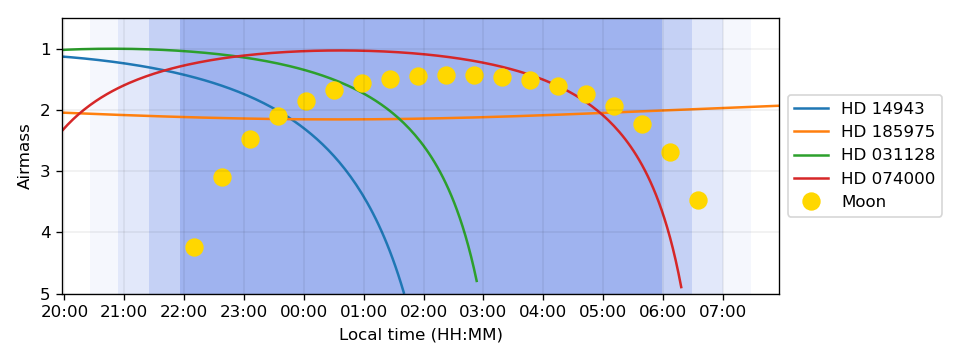

In [9]:
%matplotlib widget
fig, ax = plt.subplots(num="Airmass", dpi=120, figsize=(8, 3))
# ax.set_prop_cycle('color', ["darkgrey", "darkorange", "limegreen", "mediumpurple", "yellowgreen"])

for t, a in airmasses.items():
    ax.plot(times.to_datetime(timezone=tz), a, label=t)

ax.plot(times.to_datetime(timezone=tz)[::10], 
        moon_airmass[::10], 'o', markersize=10, color='gold', label='Moon')    
    
ax.axvspan(sun_set.to_datetime(timezone=tz), 
           end_civil_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.05)

ax.axvspan(end_civil_twilight.to_datetime(timezone=tz), 
           end_nautical_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.15)

ax.axvspan(end_nautical_twilight.to_datetime(timezone=tz), 
           end_astronomical_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.3)

ax.axvspan(end_astronomical_twilight.to_datetime(timezone=tz), 
           begin_astronomical_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.5)

ax.axvspan(begin_astronomical_twilight.to_datetime(timezone=tz), 
           begin_nautical_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.3)

ax.axvspan(begin_nautical_twilight.to_datetime(timezone=tz), 
           begin_civil_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.15)

ax.axvspan(begin_civil_twilight.to_datetime(timezone=tz), 
           sun_rise.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.05)

myFmt = mdates.DateFormatter("%H:%M", tz=tz)
ax.xaxis.set_major_formatter(myFmt)
ax.invert_yaxis()
ax.set_ylim(5, 0.5)
ax.set_xlim(
    (sun_set - (end_civil_twilight - sun_set)).to_datetime(timezone=tz), 
    (sun_rise + (sun_rise - begin_civil_twilight)).to_datetime(timezone=tz))

ax.set_axisbelow(False)
ax.grid(":", lw=0.25, color='k', alpha=0.25)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Local time (HH:MM)")
ax.set_ylabel("Airmass")

fig.tight_layout()
plt.show()

## Plotting the Elevation 

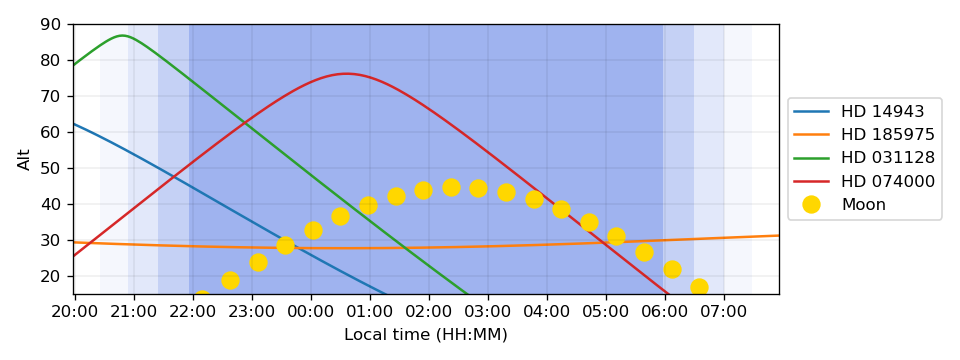

In [10]:
%matplotlib widget
fig, ax = plt.subplots(num="Elevation", dpi=120, figsize=(8, 3))

for t, a in alts.items():
    ax.plot(times.to_datetime(timezone=tz), a, label=t)

ax.plot(times.to_datetime(timezone=tz)[::10], 
        moon_elevation[::10], 'o', markersize=10, color='gold', label='Moon')     
    
ax.axvspan(sun_set.to_datetime(timezone=tz), 
           end_civil_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.05)

ax.axvspan(end_civil_twilight.to_datetime(timezone=tz), 
           end_nautical_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.15)

ax.axvspan(end_nautical_twilight.to_datetime(timezone=tz), 
           end_astronomical_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.3)

ax.axvspan(end_astronomical_twilight.to_datetime(timezone=tz), 
           begin_astronomical_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.5)

ax.axvspan(begin_astronomical_twilight.to_datetime(timezone=tz), 
           begin_nautical_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.3)

ax.axvspan(begin_nautical_twilight.to_datetime(timezone=tz), 
           begin_civil_twilight.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.15)

ax.axvspan(begin_civil_twilight.to_datetime(timezone=tz), 
           sun_rise.to_datetime(timezone=tz), 
           fc="royalblue", alpha=0.05)

myFmt = mdates.DateFormatter("%H:%M", tz=tz)
ax.xaxis.set_major_formatter(myFmt)
ax.set_axisbelow(False)
ax.grid(":", lw=0.25, color='k', alpha=0.25)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Local time (HH:MM)")
ax.set_ylabel("Alt")
ax.set_ylim(15, 90)
ax.set_xlim(
    (sun_set - (end_civil_twilight - sun_set)).to_datetime(timezone=tz), 
    (sun_rise + (sun_rise - begin_civil_twilight)).to_datetime(timezone=tz))

fig.tight_layout()
plt.show()